# Coupling of a Particle Model to a Reactor Model

This notebook demonstrates a generalized approach to coupling a reactor model with a particle model, applicable in various simulation scenarios. The examples provided focus on two distinct methodologies:

1. **Steady-State Simulations**: Suitable for scenarios involving catalytic particles, this method involves solving the particle model in a steady state. The outcome is the computation of an apparent reaction rate, which is subsequently utilized in the reactor model to simulate steady-state behavior. This approach is particularly useful for systems where the reactor conditions remain constant over time.

2. **Transient Simulations**: This method is versatile and applicable to dynamic scenarios such as adsorption processes or when the particle itself undergoes processing. It allows for the simulation of time-dependent changes, making it suitable for examining the effects of varying reactor conditions over time.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags_array, csc_array, eye_array
import scipy.sparse.linalg as sla
from scipy.linalg import norm
from pymrm import construct_grad, construct_div, construct_convflux_upwind, construct_coefficient_matrix, interp_cntr_to_stagg_tvd, minmod, upwind, newton, numjac_local, non_uniform_grid
from IPython.display import clear_output, display

## `ConvectionDiffusionReaction2D` Class

This class represents a versatile reactor model characterized by:
- **Geometry**: 2D cylindrical setup, accommodating axial convection and diffusion, alongside radial diffusion.
- **Customization of Reaction Kinetics**: Users can define reaction kinetics in one of two ways:
  - **Rate Equation**: By specifying a rate equation stored in `self.kinetics`.
  - **Reaction Function**: By providing a function `self.react` that returns both the reaction term and its Jacobian. This flexibility is particularly useful for transient analyses where the reactor model is dynamically coupled with a particle model.

### Usability Across Different Dimensions
- The class is designed to operate not only in 2D but also in reduced dimensions (1D or 0D), making it adaptable to a range of simulation scenarios.

### Initialization and Customization
- During initialization, `init_params` and `init_bc` functions are invoked:
  - **`init_params`**: Used to set up initial parameters.
  - **`init_bc`**: Establishes boundary conditions.
  
These functions facilitate easy customization and are instrumental in tailoring the class to specific simulation requirements. Examples in subsequent sections will illustrate their practical applications.

In [2]:
class ConvectionDiffusionReaction2D:
    """
    Class for simulating reaction-diffusion systems in a 2D cylindrical geometry with axial and radial components.
    
    Attributes:
    shape_c (tuple): Dimensions of the concentration grid (z, r, species).
    eps_b (float): Bed porosity.
    D_ax (float): Axial diffusion coefficient.
    v (float): Axial velocity.
    L (float): Length of the reactor.
    D_rad (float): Radial diffusion coefficient.
    R (float): Radius of the reactor.
    c_in (float): Inlet concentration.
    dt (float): Time step (infinity for steady state).
    maxfev (int): Maximum number of function evaluations in the solver.
    kinetics (callable): Kinetics model function.
    react (callable): Function to compute reaction term and its Jacobian.
    c (numpy.ndarray): Concentration field.
    z_f (numpy.ndarray): Axial face grid points.
    z_c (numpy.ndarray): Axial center grid points.
    r_f (numpy.ndarray): Radial face grid points.
    r_c (numpy.ndarray): Radial center grid points.
    bc_ax (dict): Axial boundary conditions.
    bc_rad (dict): Radial boundary conditions.
    Jac_accum (scipy.sparse.csc_matrix): Accumulation matrix for Jacobian.
    Div_ax (scipy.sparse.csc_matrix): Divergence matrix for axial direction.
    Flux_ax (scipy.sparse.csc_matrix): Flux matrix for axial direction.
    flux_ax_bc (numpy.ndarray): Axial flux boundary conditions.
    g_const (numpy.ndarray): Constant term in the residual.
    Jac_const (scipy.sparse.csc_matrix): Constant part of the Jacobian matrix.
    Flux_rad (scipy.sparse.csc_matrix): Flux matrix for radial direction.
    flux_rad_bc (numpy.ndarray): Radial flux boundary conditions.
    """

    def __init__(self, shape_c=(1, 1, 1), init_params=None, set_bc=None):
        """
        Initialize the ConvectionDiffusionReaction2D class for simulating 
        reaction-diffusion systems in a 2D cylindrical geometry with axial and radial components.

        Parameters:
        - shape_c (tuple): Dimensions of the concentration grid (z, r, species).
        - init_params (function): Optional function to initialize model parameters.
        - set_bc (function): Optional function to set boundary conditions.

        The model supports customization of reaction kinetics and boundary conditions,
        making it suitable for a wide range of chemical engineering applications.
        """
        self.shape_c = shape_c  # Grid shape
        self.eps_b = 0.4  # Bed porosity
        self.D_ax = 0.0  # Axial diffusion coefficient
        self.v = 1.0  # Axial velocity
        self.L = 1.0  # Length of the reactor
        self.D_rad = 1e-2  # Radial diffusion coefficient
        self.R = 0.1  # Radius of the reactor
        self.c_in = 1.0  # Inlet concentration
        self.dt = np.inf  # Time step (inf for steady state)
        self.maxfev = 2  # Maximum function evaluations in the solver
        self.kinetics = None  # Kinetics model
        self.react = None  # Reaction term function

        # Initialize the concentration field
        self.init_field()

        # Optional parameter initialization
        if init_params is not None:
            init_params(self)

        # Setup axial and radial grids
        self.z_f = np.linspace(0, self.L, self.shape_c[0] + 1)
        self.z_c = 0.5 * (self.z_f[:-1] + self.z_f[1:])
        self.r_f = np.linspace(0, self.R, self.shape_c[1] + 1)
        self.r_c = 0.5 * (self.r_f[:-1] + self.r_f[1:])

        # Setup boundary conditions for axial and radial directions
        self.bc_ax = {'a': [self.D_ax, 1], 'b': [self.v, 0], 'd': [self.v * self.c_in, 0]}
        self.bc_rad = {'a': [self.D_rad, self.D_rad], 'b': [0, 0], 'd': [0, 0]}

        # Optional boundary condition customization
        if set_bc is not None:
            set_bc(self)

        # Initialize Jacobian matrices for the system
        self.init_Jac()

    def init_field(self, c0=0.0):
        """
        Initialize the concentration field.

        Parameters:
        - c0 (float): Initial concentration value.
        """
        self.c = np.full(self.shape_c, c0, dtype='float')

    def init_Jac(self):
        """
        Initialize the Jacobian matrices for the system. 
        This includes setting up the accumulation, convection, and diffusion terms.
        """
        self.Jac_accum = construct_coefficient_matrix(self.eps_b / self.dt, self.c.shape)
        
        # Axial gradient and flux matrices
        Grad, grad_bc = construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        Conv, conv_bc = construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.v, axis=0)
        self.Div_ax = construct_div(self.c.shape, self.z_f, nu=0, axis=0)
        self.Flux_ax = Conv - self.D_ax * Grad
        self.flux_ax_bc = conv_bc - self.D_ax * grad_bc
        self.g_const = self.Div_ax @ self.flux_ax_bc
        self.Jac_const = self.Jac_accum + self.Div_ax @ self.Flux_ax

        # Radial gradient and flux matrices
        Grad, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc_rad, axis=1)
        Div_rad = construct_div(self.c.shape, self.r_f, nu=1, axis=1)
        self.Flux_rad = - self.D_rad * Grad
        self.flux_rad_bc = - self.D_rad * grad_bc
        self.g_const += Div_rad @ self.flux_rad_bc
        self.Jac_const += Div_rad @ self.Flux_rad

    def construct_g(self, c, c_old):
        """
        Construct the residual vector g and the Jacobian matrix for the system.

        Parameters:
        - c (numpy.ndarray): Current concentration field.
        - c_old (numpy.ndarray): Previous concentration field.

        Returns:
        - g (numpy.ndarray): Residual vector.
        - Jac (scipy.sparse.csc_matrix): Jacobian matrix.
        """
        c_f, dc_f = interp_cntr_to_stagg_tvd(self.c, self.z_f, self.z_c, self.bc_ax, self.v, minmod, axis=0)
        dg_conv = self.Div_ax @ (self.v * dc_f).reshape((-1, 1))
        
        if self.kinetics is not None:
            g_react, Jac_react = numjac_local(self.kinetics, c)
        else:
            g_react = np.array([0])
            Jac_react = 0.0
        
        if self.react is not None:
            g_react2, Jac_react2 = self.react(c)
            g_react = g_react + g_react2
            Jac_react = Jac_react + Jac_react2
        
        g = (self.g_const + self.Jac_const @ c.reshape((-1, 1)) + dg_conv - 
             self.Jac_accum @ c_old.reshape((-1, 1)) - (1.0 - self.eps_b) * g_react.reshape((-1, 1)))
        Jac = self.Jac_const - (1.0 - self.eps_b) * Jac_react
        
        return g, Jac

    def solve(self, num_timesteps=1):
        """
        Solve the system for a specified number of time steps.

        Parameters:
        - num_timesteps (int): Number of time steps to solve for.
        """
        for i in range(num_timesteps):
            c_old = self.c.copy()  # Copy the current concentration field
            result = newton(lambda c: self.construct_g(c, c_old), c_old, maxfev=self.maxfev)
            self.c = result.x  # Update concentration field with the result from Newton's method


## `ParticleModel` Class

The `ParticleModel` class represents a 1D spherically symmetric diffusion equation with user-defined kinetics. Although the design is similar to the `ConvectionDiffusionReaction2D` class, there are key differences and specialized functionalities:

### Key Features and Design Considerations

- **Storage Efficiency**: The concentration profiles within a particle are not stored within the class. This design choice is made because the particle model will be utilized in each grid cell of the reactor model.
  
- **Boundary Conditions**: The boundary conditions handle the fluid concentration at the boundary (`c_f`) separately. This separation ensures that the `d`-term of the boundary condition is not directly tied to `c_f`.

- **Flexible Initialization**: The `solve` method allows the user to specify both the initial species concentration inside the particle and the fluid concentration (`c_f`). This flexibility is crucial for accurately simulating transient behaviors and initial conditions.

### Coupling with Reactor Model

The `ParticleModel` class includes several attributes and methods designed for effective coupling with a reactor model:
- **`Jac_sf`**: Jacobian matrix for the species flux.
- **`Jac_rate_app_s`**: Jacobian matrix for the apparent reaction rate concerning the species concentration.
- **`Jac_rate_app_f`**: Jacobian matrix for the apparent reaction rate concerning the fluid concentration.
- **`rate_app(self, c, c_f)`**: Method to compute the apparent reaction rate based on species and fluid concentrations.
- **`compute_DcsDcf(self)`**: Method to compute the derivative of the species concentration with respect to the fluid concentration.

These features make the `ParticleModel` class highly versatile and suitable for detailed simulations of particle behavior within reactor models.


In [3]:
class ParticleModel:
    """
    Class representing a 1D spherical symmetric diffusion model with user-provided kinetics.
    
    Attributes:
    shape_c (tuple): Dimensions of the concentration grid (r, species).
    D (float): Diffusion coefficient.
    R (float): Radius of the particle.
    dt (float): Time step (infinity for steady state).
    dr_large (float): Initial large grid spacing.
    refinement_factor (float): Factor for refining the grid.
    maxfev (int): Maximum number of function evaluations in the solver.
    kinetics (callable): Kinetics model function.
    r_f (numpy.ndarray): Radial face grid points.
    r_c (numpy.ndarray): Radial center grid points.
    bc (dict): Boundary conditions.
    Flux (scipy.sparse.csc_matrix): Flux matrix.
    flux_bc (numpy.ndarray): Flux boundary conditions.
    Jac_sf (scipy.sparse.csc_matrix): Jacobian matrix for the species flux.
    Jac_rate_app_s (scipy.sparse.csc_matrix): Jacobian matrix for the apparent reaction rate concerning species concentration.
    Jac_rate_app_f (scipy.sparse.csc_matrix): Jacobian matrix for the apparent reaction rate concerning fluid concentration.
    Jac_const (scipy.sparse.csc_matrix): Constant part of the Jacobian matrix.
    Jac_ss (scipy.sparse.csc_matrix): Steady-state Jacobian matrix.
    """

    def __init__(self, shape_c=(30, 1), init_params=None, set_bc=None):
        """
        Initialize the ParticleModel class.

        Parameters:
        - shape_c (tuple): Dimensions of the concentration grid (r, species).
        - init_params (function): Optional function to initialize model parameters.
        - set_bc (function): Optional function to set boundary conditions.
        """
        self.shape_c = shape_c
        self.D = 1.0  # Diffusion coefficient
        self.R = 1.0  # Radius of the particle
        self.dt = np.inf  # Time step (infinity for steady state)
        self.dr_large = 0.1 * self.R  # Initial large grid spacing
        self.refinement_factor = 0.75  # Factor for refining the grid
        self.maxfev = 2  # Maximum function evaluations in the solver
        self.kinetics = lambda c: np.zeros_like(c)  # Default kinetics function returning zeros

        # Optional parameter initialization
        if init_params is not None:
            init_params(self)

        # Setup radial grid
        self.r_f = non_uniform_grid(0, self.R, self.shape_c[0] + 1, self.dr_large, self.refinement_factor)
        self.r_c = 0.5 * (self.r_f[:-1] + self.r_f[1:])

        # Default boundary conditions
        self.bc = {'a': [1, 0], 'b': [0, 1], 'd': [0, 1]}

        # Optional boundary condition customization
        if set_bc is not None:
            set_bc(self)

        # Initialize Jacobian matrices for the system
        self.init_Jac()

    def init_Jac(self):
        """
        Initialize the Jacobian matrices for the system.
        This includes setting up the accumulation, gradient, and divergence terms.
        """
        Jac_accum = construct_coefficient_matrix(1.0 / self.dt, self.shape_c)
        
        # Gradient and flux matrices
        Grad, grad_bc = construct_grad(self.shape_c, self.r_f, self.r_c, self.bc)
        self.Div = construct_div(self.shape_c, self.r_f, nu=2)
        self.Flux = -self.D * Grad
        self.flux_bc = -self.D * grad_bc
        
        # Indices for constructing sparse matrices
        size_c_f = math.prod(self.shape_c[1:])
        indx_j = np.arange(size_c_f)
        indx_i = size_c_f * self.shape_c[0] + indx_j
        
        # Sparse flux matrix for species-fluid interaction
        self.Flux_sf = csc_array((self.flux_bc[indx_i, [0]], (indx_i, indx_j)), 
                                 shape=(size_c_f * (self.shape_c[0] + 1), size_c_f))
        self.Jac_sf = self.Div @ self.Flux_sf
        
        # Boundary fluxes for apparent reaction rate calculations
        last_face = range(-self.shape_c[-1], 0)
        self.Jac_rate_app_s = 3.0 / self.R * self.Flux[last_face, :]
        self.Jac_rate_app_f = 3.0 / self.R * self.Flux_sf[last_face, :]
        
        # Constant part of the Jacobian matrix
        self.Jac_const = Jac_accum + self.Div @ self.Flux

    def construct_g(self, c, c_old, c_f):
        """
        Construct the residual vector g and the Jacobian matrix for the system.

        Parameters:
        - c (numpy.ndarray): Current concentration field.
        - c_old (numpy.ndarray): Previous concentration field.
        - c_f (numpy.ndarray): Fluid concentration at the boundary.

        Returns:
        - g (numpy.ndarray): Residual vector.
        - Jac (scipy.sparse.csc_matrix): Jacobian matrix.
        """
        # Reaction term and its Jacobian
        g_react, Jac_react = numjac_local(self.kinetics, c)
        
        # Residual vector
        g = (self.Jac_sf @ c_f.reshape((-1, 1)) + self.Jac_const @ c.reshape((-1, 1)) - 
             c_old.reshape((-1, 1)) / self.dt - g_react.reshape((-1, 1)))
        
        # Jacobian matrix
        Jac = self.Jac_const - Jac_react
        
        # Store steady-state Jacobian for later use
        self.Jac_ss = Jac
        
        return g, Jac

    def compute_DcsDcf(self):
        """
        Compute the derivative of the species concentration with respect to the fluid concentration.

        Returns:
        - DcsDcf (numpy.ndarray): Derivative matrix.
        """
        DcsDcf = (-sla.spsolve(self.Jac_ss, self.Jac_sf)).toarray()
        return DcsDcf

    def rate_app(self, c, c_f):
        """
        Compute the apparent reaction rate based on species and fluid concentrations.

        Parameters:
        - c (numpy.ndarray): Species concentration.
        - c_f (numpy.ndarray): Fluid concentration at the boundary.

        Returns:
        - rate (numpy.ndarray): Apparent reaction rate.
        """
        return (self.Jac_rate_app_s @ c.reshape((-1, 1)) + self.Jac_rate_app_f @ c_f.reshape((-1, 1))).reshape((-1,))

    def solve(self, c, c_f, num_timesteps=1):
        """
        Solve the system for a specified number of time steps.

        Parameters:
        - c (numpy.ndarray): Initial species concentration.
        - c_f (numpy.ndarray): Fluid concentration at the boundary.
        - num_timesteps (int): Number of time steps to solve for.

        Returns:
        - c (numpy.ndarray): Updated species concentration after solving.
        """
        for i in range(num_timesteps):
            c_old = c.copy()  # Copy the current concentration field
            result = newton(lambda c: self.construct_g(c, c_old, c_f), c_old, maxfev=self.maxfev)
            c = result.x  # Update concentration field with the result from Newton's method
        return c

## `RateApparent` Class

The `RateApparent` class is designed to integrate a particle model with a reactor model by providing the steady-state apparent reaction rate.

### Key Features

- **Initialization with Particle Model**: The class is initialized with a particle model, which it uses to compute reaction rates.
- **Steady-State Apparent Reaction Rate**: It computes the apparent reaction rate in a steady-state scenario, which can be directly used in reactor model simulations.

### Methods

- **`__init__(self, particle_model)`**: Initializes the `RateApparent` class with the provided particle model.
- **`rate(self, c_f)`**: Computes the apparent reaction rate for given fluid concentrations `c_f`.

This class is essential for coupling detailed particle-level reactions to larger-scale reactor models, enabling more accurate and comprehensive simulations.

In [4]:
class RateApparent:
    """
    Class to integrate a particle model with a reactor model by providing the steady-state apparent reaction rate.

    Attributes:
    particle_model (ParticleModel): Instance of the ParticleModel class used to compute reaction rates.
    """
    
    def __init__(self, particle_model):
        """
        Initialize the RateApparent class with a particle model.

        Parameters:
        - particle_model (ParticleModel): An instance of the ParticleModel class.
        """
        self.particle_model = particle_model
    
    def rate(self, c_f):
        """
        Compute the apparent reaction rate for given fluid concentrations `c_f`.

        Parameters:
        - c_f (numpy.ndarray): Fluid concentration array.

        Returns:
        - r (numpy.ndarray): Apparent reaction rate array with the same shape as `c_f`.
        """
        shape_c_f = c_f.shape  # Original shape of the fluid concentration array
        c_f = c_f.reshape((-1, shape_c_f[-1]))  # Reshape to 2D array for processing
        r = np.empty_like(c_f)  # Allocate the reaction rate array
        
        # Loop over each fluid concentration to compute the reaction rate
        for i in range(c_f.shape[0]):
            # Solve the particle model for the current fluid concentration
            c_s = self.particle_model.solve(np.zeros(self.particle_model.shape_c), c_f[i, :])
            # Compute the apparent reaction rate for the current concentrations
            r[i, :] = self.particle_model.rate_app(c_s, c_f[i, :])
        
        # Reshape the reaction rate array to its original shape
        r = r.reshape(shape_c_f)
        return r


# Example Kinetics

The following example demonstrates a kinetic model for a 3-component system involving the reactions A ↔ B → C. 

The kinetic model is defined as follows:

In [5]:
num_c = 3

def kinetics(c):
    """
    Compute the reaction rates for a 3-component system involving the reactions A ↔ B → C.

    Parameters:
    - c (numpy.ndarray): Concentration array with the last dimension corresponding to the components [A, B, C].

    Returns:
    - r (numpy.ndarray): Reaction rate array with the same shape as the input concentration array.
    """
    k1 = 10.0  # Forward rate constant for A ↔ B
    k_1 = 5.0  # Backward rate constant for A ↔ B
    k2 = 5.0   # Rate constant for B → C

    # Compute the reaction rates for the forward and backward reactions
    r1 = k1 * c[..., 0]  # Rate of A → B
    r2 = k_1 * c[..., 1]  # Rate of B → A
    r3 = k2 * c[..., 1]  # Rate of B → C

    # Initialize the reaction rate array with the same shape as c
    r = np.empty_like(c)

    # Calculate the net reaction rates for each component
    r[..., 0] = -r1 + r2  # Net rate for component A
    r[..., 1] = r1 - r2 - r3  # Net rate for component B
    r[..., 2] = r3  # Net rate for component C

    return r


A 2D plotting function used in the examples below.

In [6]:
def plot_model_2D(model):
    """
    Plot the 2D concentration fields of a multi-component model.

    This function creates a 2D plot for each component of the concentration field
    in the given model. Each plot is displayed as a separate subplot in a single figure.

    Parameters:
    - model: An object containing the concentration field and grid information. 
      The model is expected to have the following attributes:
        - model.shape_c: A tuple representing the shape of the concentration field array.
        - model.r_f: Radial face grid points.
        - model.z_f: Axial face grid points.
        - model.c: Concentration field array with the last dimension corresponding to components.
    """
    # Number of components in the concentration field
    num_c = model.shape_c[2]

    # Create a figure with subplots for each component
    fig, axes = plt.subplots(nrows=1, ncols=num_c, figsize=(4 * num_c, 3))

    # Ensure axes is always a list, even if there is only one component
    if num_c == 1:
        axes = [axes]

    # Initialize a list to store the contour plots
    contours = [None] * num_c

    # Iterate over each component and create a pcolormesh plot
    for idx, ax in enumerate(axes):
        contour = ax.pcolormesh(model.r_f, model.z_f, model.c[:, :, idx], shading='flat', cmap='viridis', vmin=0, vmax=1)
        contours[idx] = contour  # Store the contour plot
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_xticklabels([])  # Remove x-axis labels
        ax.set_yticklabels([])  # Remove y-axis labels
        ax.set_title(f'Component {idx + 1}')  # Set the title for each subplot

    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.92, axes[0].get_position().y0, 0.02, axes[0].get_position().y1 - axes[0].get_position().y0])
    plt.colorbar(contours[0], cax=cbar_ax)

    # Display the plot
    plt.show()


The functions `init_params_column` and `set_bc_column(model)` are used in all examples below to configure the parameters of the column model.

- **`init_params_column`**: This function sets the parameters of the column model. In particular, it sets the time-step to infinity to ensure that a steady-state solution is computed.

- **`set_bc_column(model)`**: This function defines the boundary conditions for the column model. Specifically, it specifies that component A is removed at the wall, while components B and C follow Neumann boundary conditions.

Additionally, the function `init_params_particle(model)` is used to configure the parameters of the particle model.


In [7]:
def init_params_column(model):
    """
    Initialize the parameters for the column model.

    This function sets the kinetic model, time-step, maximum number of function evaluations,
    initial concentration, and inlet concentration for the column model.

    Parameters:
    - model: An instance of the column model to be initialized.
    """
    model.kinetics = kinetics  # Set the kinetic model
    model.dt = np.inf  # Set time-step to infinity for steady-state solution
    model.maxfev = 2  # Set the maximum number of function evaluations
    model.c0 = np.array([[[0.0, 0.0, 1.0]]])  # Initial concentration for the model
    model.c_in = np.array([[[1.0, 0.0, 0.0]]])  # Inlet concentration for the model

def set_bc_column(model):
    """
    Set the boundary conditions for the column model.

    This function defines the radial boundary conditions for the column model.
    Component A is removed at the wall, while components B and C follow Neumann boundary conditions.

    Parameters:
    - model: An instance of the column model to set boundary conditions for.
    """
    model.bc_rad = {
        'a': [1, [[[0, 1, 1]]]],  # On tube wall components B and C Neumann BC
        'b': [0, [[[1, 0, 0]]]],  # On tube wall components A reacts away
        'd': [0, 0]  # Homogeneous BC
    }

def init_params_particle(model):
    """
    Initialize the parameters for the particle model.

    This function sets the kinetic model, time-step, maximum number of function evaluations,
    and the diffusion coefficient for the particle model.

    Parameters:
    - model: An instance of the particle model to be initialized.
    """
    model.kinetics = kinetics  # Set the kinetic model
    model.dt = np.inf  # Set time-step to infinity for steady-state solution
    model.maxfev = 5  # Set the maximum number of function evaluations
    model.D = 1e-3  # Set the diffusion coefficient

    

### Example: Steady-State Solution of the Column Model with Specified Kinetics

This example demonstrates how to compute a steady-state solution for the column model using the specified kinetics. The model is configured to simulate the reaction-diffusion process under steady-state conditions, utilizing the kinetic parameters and boundary conditions defined earlier.


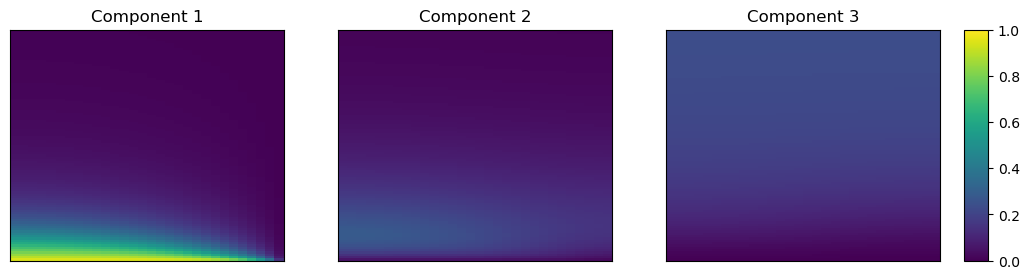

In [8]:
# Initialize the column model with the specified shape, parameters, and boundary conditions
# The shape_c parameter defines the dimensions of the concentration grid: (z, r, species)
column_model = ConvectionDiffusionReaction2D(
    shape_c=(100, 30, num_c),          # 100 axial points, 30 radial points, num_c components
    init_params=init_params_column,    # Initialize parameters using the init_params_column function
    set_bc=set_bc_column               # Set boundary conditions using the set_bc_column function
)

# Optional: Initialize a simpler 1D column model by setting the radial dimension to 1
# This can be useful for testing or simpler simulations
# column_model = ConvectionDiffusionReaction2D(
#     shape_c=(100, 1, num_c),           # 100 axial points, 1 radial point, num_c components
#     init_params=init_params_column,    # Initialize parameters using the init_params_column function
# )

# Solve the column model to find the steady-state solution with column_model.dt = np.inf
column_model.solve()

# Plot the 2D concentration fields for each component in the model
plot_model_2D(column_model)


### Example: Particle model with the intrinsic kinetics

Example of a steady-state solution of the particle model using the specified kinetics.## Steady-State Solution of the Particle Model with Intrinsic Kinetics

This example demonstrates how to compute a steady-state solution for the particle model using the specified intrinsic kinetics. The model is configured to simulate the reaction-diffusion process within a particle under steady-state conditions, utilizing the predefined kinetic parameters.


Apparent reaction rates: [-0.2322312   0.02495924  0.20727196] vs intrinsic reaction rates [[-7.5  5.   2.5]]


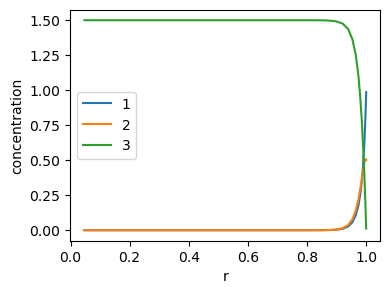

In [9]:
# Define the fluid concentration at the boundary for the particle model
c_f = np.array([[1.0, 0.5, 0.0]])

# Initialize the initial concentration inside the particle to zero for all components
c = np.zeros((30, num_c))

# Initialize the particle model with the specified shape and parameters
particle_model = ParticleModel(shape_c=c.shape, init_params=init_params_particle)

# Solve the particle model to find the steady-state concentration profiles
# c: initial concentration inside the particle
# c_f: fluid concentration at the boundary
c = particle_model.solve(c, c_f)

# Print the apparent reaction rates computed by the particle model and compare them with the intrinsic reaction rates
print(f'Apparent reaction rates: {particle_model.rate_app(c, c_f)} vs intrinsic reaction rates {kinetics(c_f)}')

# Plot the concentration profiles within the particle
plt.figure(figsize=(4, 3))  # Set the figure size
plt.plot(particle_model.r_c, c)  # Plot the concentration profiles for each component
plt.xlabel('r')  # Label the x-axis as 'r' (radius)
plt.ylabel('concentration')  # Label the y-axis as 'concentration'
plt.legend(['A', 'B', 'C'])  # Add a legend for the components
plt.show()  # Display the plot

### Example: Using the Apparent Reaction Rate from the Particle Model in the Column Model

This example demonstrates how to use the steady-state apparent reaction rate, computed from the particle model, in the column model. Here, the `RateApparent` class is utilized to compute the kinetics, integrating the detailed particle-level reactions into the larger-scale column model.

The implementation is similar to the one using intrinsic kinetics, with the key difference being the computation of the reaction rates through the particle model.

**Note**: Running this model typically takes around 1 minute, so please be patient while the simulation completes.

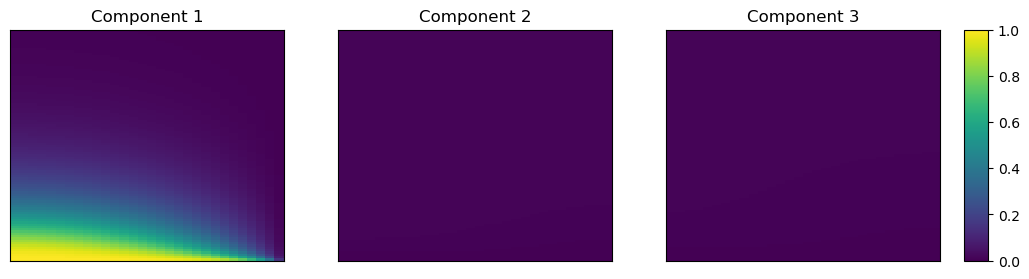

In [10]:
def init_params_column_pm(model):
    """
    Initialize the parameters for the column model with particle model kinetics.

    This function first sets the standard parameters for the column model using
    `init_params_column`. It then replaces the kinetic model with the apparent
    reaction rate computed by the `RateApparent` class, which integrates the particle model.

    Parameters:
    - model: An instance of the column model to be initialized.
    """
    init_params_column(model)  # Initialize standard parameters for the column model
    model.kinetics = RateApparent(particle_model).rate  # Set kinetics to use apparent reaction rate from particle model

# Initialize the column model with particle model kinetics
# The shape_c parameter defines the dimensions of the concentration grid: (z, r, species)
column_model_pm = ConvectionDiffusionReaction2D(
    shape_c=(100, 30, num_c),           # 100 axial points, 30 radial points, num_c components
    init_params=init_params_column_pm,  # Initialize parameters using init_params_column_pm
    set_bc=set_bc_column                # Set boundary conditions using set_bc_column
)

# Optional: Initialize a simpler 1D column model by setting the radial dimension to 1
# This can be useful for testing or simpler simulations
# column_model_pm = ConvectionDiffusionReaction2D(
#     shape_c=(100, 1, num_c),           # 100 axial points, 1 radial point, num_c components
#     init_params=init_params_column_pm,  # Initialize parameters using init_params_column_pm
#     set_bc=set_bc_column                # Set boundary conditions using set_bc_column
# )

# Solve the column model to find the steady-state solution
column_model_pm.solve()

# Plot the 2D concentration fields for each component in the model
plot_model_2D(column_model_pm)


## `CoupledColumnParticleModel` Class

The `CoupledColumnParticleModel` class integrates a particle model with a column model, enabling the simulation of reaction-diffusion processes where detailed particle-level reactions are coupled with larger-scale column behavior.

### Key Features

- **Initialization with Models**: The class is initialized with both a particle model and a column model, allowing detailed interactions between the two.
- **Coupled Solving Routine**: It employs its own solve routine that simultaneously solves both models in a coupled manner using the Schur complement approach. This method ensures accurate and consistent interaction between the particle and column models.
- **Steady-State and Transient Capabilities**: While the provided example demonstrates a steady-state solution, the class is designed to handle transient simulations as well, making it versatile for various simulation scenarios.

### Use Cases

- **Catalytic Processes**: Simulate catalytic reactions where the catalyst is within the particles, and reactants flow through the column.
- **Adsorption and Desorption**: Model adsorption and desorption processes with detailed particle behavior affecting the overall column dynamics.
- **General Reaction-Diffusion Systems**: Suitable for any scenario where detailed particle-level reactions need to be coupled with larger-scale column behavior.

The following example demonstrates the steady-state application of this coupled model.

In [11]:
class CoupledColumnParticleModel:
    """
    Class for coupling a particle model with a column model, enabling the simulation of reaction-diffusion processes
    with detailed particle-level reactions integrated into a larger-scale column model.

    Attributes:
    num_c (int): Number of components in the model.
    shape_c_f (tuple): Shape of the concentration field in the column model.
    shape_c_s (tuple): Shape of the concentration field in the particle model.
    c_s (numpy.ndarray): Concentration field in the particle model.
    pm (ParticleModel): Instance of the ParticleModel class.
    cm (ConvectionDiffusionReaction2D): Instance of the ConvectionDiffusionReaction2D class.
    tol (float): Tolerance for convergence in the coupled solve routine.
    """
    
    def __init__(self):
        """
        Initialize the CoupledColumnParticleModel class.

        This method sets up the particle model and column model with their respective parameters
        and initializes the concentration fields and tolerance for convergence.
        """
        self.num_c = 3  # Number of components
        shape_domain = (100, 30)  # Shape of the domain (axial, radial)
        self.num_xi = 30  # Number of grid points in the particle model
        self.tol = 1.49012e-08  # Convergence tolerance
        shape_c_p = (self.num_xi, self.num_c)  # Shape of the particle concentration field
        self.shape_c_f = shape_domain + (self.num_c,)  # Shape of the column concentration field
        self.shape_c_s = shape_domain + (self.num_xi, self.num_c)  # Shape of the combined concentration field
        self.c_s = np.empty(self.shape_c_s)  # Initialize the particle concentration field
        
        # Initialize the particle model with specific parameters
        self.pm = ParticleModel(shape_c_p, init_params=self.init_pm)
        
        # Initialize the column model with specific parameters and boundary conditions
        self.cm = ConvectionDiffusionReaction2D(self.shape_c_f, init_params=self.init_cm, set_bc=set_bc_column)
        # For 1D test case, you can initialize the column model as below (commented out)
        # self.cm = ConvectionDiffusionReaction2D(self.shape_c_f, init_params=self.init_cm)

    def init_common(self, model):
        """
        Initialize common parameters for both particle and column models.

        Parameters:
        - model: An instance of the model (either particle or column) to be initialized.
        """
        model.dt = np.inf  # Set time-step to infinity for steady-state solution
        model.c0 = 0  # Initial concentration

    def init_cm(self, model):
        """
        Initialize parameters for the column model.

        This method sets up the column model using the init_params_column function
        and then initializes common parameters and specific reaction terms.

        Parameters:
        - model: An instance of the column model to be initialized.
        """
        init_params_column(model)  # Initialize standard parameters for the column model
        self.init_common(model)  # Initialize common parameters
        model.kinetics = None  # No intrinsic kinetics
        model.react = self.react_app  # Use the reaction term from the coupled model

    def init_pm(self, model):
        """
        Initialize parameters for the particle model.

        This method sets up the particle model using the init_params_particle function
        and then initializes common parameters.

        Parameters:
        - model: An instance of the particle model to be initialized.
        """
        init_params_particle(model)  # Initialize standard parameters for the particle model
        self.init_common(model)  # Initialize common parameters

    def react_app(self, c_f):
        """
        Compute the apparent reaction rate and its Jacobian.

        Parameters:
        - c_f (numpy.ndarray): Fluid concentration.

        Returns:
        - tuple: Apparent reaction rate and its Jacobian.
        """
        return self.r_app, self.Jac_r_app

    def solve(self, num_timesteps=1):
        """
        Solve the coupled column and particle models.

        This method uses the Schur complement approach to solve both models in a coupled manner.
        It iterates over the specified number of time steps to achieve a steady-state or transient solution.

        Parameters:
        - num_timesteps (int): Number of time steps to solve for.
        """
        # Convert Jacobian of the apparent reaction rate from sparse to dense format
        Jac_rate_app_f = self.pm.Jac_rate_app_f.toarray()
        
        # Number of cells in the column model
        num_cell = math.prod(self.cm.c.shape[0:-1])
        num_tot = num_cell * self.num_c
        
        # Generate indices for constructing sparse matrices
        indx_i = (np.arange(0, num_tot, self.num_c).reshape((-1, 1, 1)) + 
                  np.arange(self.num_c).reshape((1, -1, 1)) + 
                  np.zeros((1, 1, self.num_c), dtype=int)).ravel()
        indx_j = (np.arange(0, num_tot, self.num_c).reshape((-1, 1, 1)) + 
                  np.arange(self.num_c).reshape((1, 1, -1)) + 
                  np.zeros((1, self.num_c, 1), dtype=int)).ravel()
        
        # Initialize arrays for storing intermediate results
        jac_block_r_app = np.empty((num_cell, self.num_c, self.num_c))
        DcsDcf = np.empty((self.shape_c_s) + (self.num_c,)).reshape((num_cell, -1, self.num_c))
        self.r_app = np.empty((self.shape_c_f))
        c_s_t = self.c_s.reshape((num_cell, -1, self.num_c))
        
        # Iterate over time steps
        for i in range(num_timesteps):
            c_f = self.cm.c
            c_f_old = c_f.copy()
            c_s_t_old = c_s_t.copy()
            c_f_b = c_f.reshape((num_cell, self.num_c))
            r_app_b = self.r_app.reshape((num_cell, self.num_c))
            converged = False
            it = 0
            while not converged and it < self.cm.maxfev:
                it += 1
                for j in range(num_cell):
                    # Solve the particle model for each cell in the column model
                    result = newton(lambda c: self.pm.construct_g(c, c_s_t_old[j, :, :], c_f_b[j, :]), c_s_t[j, :, :], maxfev=1)
                    c_s_t[j, :, :] = result.x
                    DcsDcf[j, :, :] = self.pm.compute_DcsDcf()
                    r_app_b[j, :] = self.pm.rate_app(c_s_t[j, :, :], c_f_b[j, :])
                    jac_block_r_app[j, :, :] = Jac_rate_app_f + self.pm.Jac_rate_app_s @ DcsDcf[j, :, :]
                
                # Construct the Jacobian matrix for the coupled system
                self.Jac_r_app = csc_array((jac_block_r_app.ravel(), (indx_i, indx_j)), shape=(num_tot, num_tot))
                
                # Solve the column model for the current time step
                result = newton(lambda c: self.cm.construct_g(c, c_f_old), c_f, maxfev=1)
                dc_f = result.x.reshape((num_cell, self.num_c)) - c_f_b
                defect = norm(dc_f[:], ord=np.inf)
                converged = (defect < self.tol)
                self.cm.c = result.x
                
                # Update the particle model concentrations based on the new column model concentrations
                c_s_t += np.sum(DcsDcf * dc_f.reshape((-1, 1, self.num_c)), axis=2).reshape((num_cell, -1, self.num_c))
        
        # Reshape the concentration field for the particle model
        self.c_s = c_s_t.reshape(self.shape_c_s)

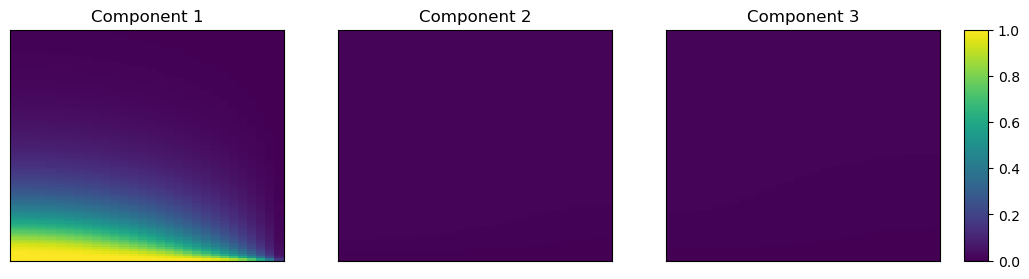

In [12]:
# Initialize the coupled column-particle model
coupled_model = CoupledColumnParticleModel()

# Solve the coupled model to find the steady-state or transient solution
# This involves solving both the particle model and the column model in a coupled manner
coupled_model.solve()

# Plot the 2D concentration fields for each component in the column model
# This visualizes the concentration profiles resulting from the coupled simulation
plot_model_2D(coupled_model.cm)